# Plotting 500-hPa CESM2-LENS Wind Speed Anomalies
Author: McKenzie Larson

Code for Fig. 16b of NCAR High Winds BAMS paper [in prep.]

In [7]:
import os
import csv
import numpy as np              
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt   
import matplotlib.colors as colors  
import matplotlib.ticker as tkr
%matplotlib inline
import xarray as xr           
import pandas as pd                 
import netCDF4 as nc               
import glob
import metpy.calc as mpcalc
from datetime import datetime
import matplotlib.units as munits
from matplotlib import colors as mcolors
from matplotlib.gridspec import GridSpec
from wrf import getvar, interplevel

import warnings
warnings.filterwarnings('ignore')

import matplotlib
from netCDF4 import Dataset
from xarray import DataArray
import matplotlib.style as style
import cartopy.crs as ccrs          # For plotting maps
import cartopy.feature as cfeature  # For plotting maps

print('Done importing modules now')

Done importing modules now


In [3]:
DATA_DIRECTORY = '/glade/derecho/scratch/mckenziel/Jan17_1982_CESMLE_10ens/'

############# future ###################
#read in U and V winds
filenames_U = sorted([f for f in glob.glob(DATA_DIRECTORY+"orig_CESMLENS_10ens_DATA/*SSP370*.h0.U*")])
filenames_V = sorted([f for f in glob.glob(DATA_DIRECTORY+"orig_CESMLENS_10ens_DATA/*SSP370*.h0.V*")])
ds_U = xr.open_mfdataset(filenames_U, 
                       concat_dim = 'time',
                      combine = 'nested',
                      parallel=True)
ds_V = xr.open_mfdataset(filenames_V, 
                       concat_dim = 'time',
                      combine = 'nested',
                      parallel=True)

## Only select DJF 2081-2100 for the future data
ds_U_mon_avg_future = ds_U.where(ds_U['time.year'] >= 2081, drop = True)
ds_U_mon_avg_future = ds_U_mon_avg_future.where(ds_U_mon_avg_future['time.year'] < 2101, drop = True)
ds_U_DJF_avg_future = xr.concat([ds_U_mon_avg_future.where(ds_U_mon_avg_future['time.month'] == 12 , drop = True),ds_U_mon_avg_future.where(ds_U_mon_avg_future['time.month'] == 1 , drop = True),
                                 ds_U_mon_avg_future.where(ds_U_mon_avg_future['time.month'] == 2 , drop = True)], dim='time')
ds_U_DJF_avg_future = ds_U_DJF_avg_future.mean('time')

ds_V_mon_avg_future = ds_V.where(ds_V['time.year'] >= 2081, drop = True)
ds_V_mon_avg_future = ds_V_mon_avg_future.where(ds_V_mon_avg_future['time.year'] < 2101, drop = True)
ds_V_DJF_avg_future = xr.concat([ds_V_mon_avg_future.where(ds_V_mon_avg_future['time.month'] == 12, drop = True),ds_V_mon_avg_future.where(ds_V_mon_avg_future['time.month'] == 1, drop = True),
                                 ds_V_mon_avg_future.where(ds_V_mon_avg_future['time.month'] == 2, drop = True)],dim='time')
ds_V_DJF_avg_future = ds_V_DJF_avg_future.mean('time')

########### historical #################
filenames_U_hist = sorted([f for f in glob.glob(DATA_DIRECTORY+"orig_CESMLENS_10ens_DATA/*HIST*.h0.U*")])
filenames_V_hist = sorted([f for f in glob.glob(DATA_DIRECTORY+"orig_CESMLENS_10ens_DATA/*HIST*.h0.V*")])

ds_U_hist = xr.open_mfdataset(filenames_U_hist, 
                       concat_dim = 'time',
                      combine = 'nested',
                      parallel=True)
ds_V_hist = xr.open_mfdataset(filenames_V_hist, 
                       concat_dim = 'time',
                      combine = 'nested',
                      parallel=True)

## Only select DJF 1991-2010 for the histogrical data
ds_U_mon_avg_hist = ds_U_hist.where(ds_U_hist['time.year'] >= 1991, drop = True)
ds_U_mon_avg_hist = ds_U_mon_avg_hist.where(ds_U_mon_avg_hist['time.year'] < 2011, drop = True)
ds_U_DJF_avg_hist = xr.concat([ds_U_mon_avg_hist.where(ds_U_mon_avg_hist['time.month'] == 12, drop = True), ds_U_mon_avg_hist.where(ds_U_mon_avg_hist['time.month'] == 1, drop = True), 
                               ds_U_mon_avg_hist.where(ds_U_mon_avg_hist['time.month'] == 2, drop = True)],dim='time')
ds_U_DJF_avg_hist = ds_U_DJF_avg_hist.mean('time')

ds_V_mon_avg_hist = ds_V_hist.where(ds_V_hist['time.year'] >= 1991, drop = True)
ds_V_mon_avg_hist = ds_V_mon_avg_hist.where(ds_V_mon_avg_hist['time.year'] < 2011, drop = True)
ds_V_DJF_avg_hist = xr.concat([ds_V_mon_avg_hist.where(ds_V_mon_avg_hist['time.month'] == 12, drop = True), ds_V_mon_avg_hist.where(ds_V_mon_avg_hist['time.month'] == 1, drop = True), 
                               ds_V_mon_avg_hist.where(ds_V_mon_avg_hist['time.month'] == 2, drop = True)],dim='time')
ds_V_DJF_avg_hist = ds_V_DJF_avg_hist.mean('time')

## Wind speed = ( U^2 + V^2 )^0.5
WS_future = (ds_U_DJF_avg_future['U']**2 + ds_V_DJF_avg_future['V']**2)**0.5
WS_hist = (ds_U_DJF_avg_hist['U']**2 + ds_V_DJF_avg_hist['V']**2)**0.5

## subtract the historical wind speed from future wind speed to get the anomaly
WS_anom = WS_future - WS_hist

In [4]:
## We are comparing with 500-hPa ERA5 wind speed, so interpolate to 500 hPa
## need an array with all of the original levels for the wrf-python interplevel function to work
WS_anom_original_levs = np.zeros([len(WS_anom.lev),len(WS_anom.lat),len(WS_anom.lon)])
for i in range(len(WS_anom.lev)):
    WS_anom_original_levs[i].fill(WS_anom.lev[i])

## interpolate!
WS_anom_500interp = interplevel(WS_anom, WS_anom_original_levs, 500.0)
WS_anom_500interp

<xarray.DataArray 'None_interp' (lat: 192, lon: 288)>
array([[ 0.32013273,  0.32013234,  0.32013285, ...,  0.32013267,
         0.32013267,  0.320133  ],
       [ 0.2581658 ,  0.25676495,  0.25541922, ...,  0.26266706,
         0.2611196 ,  0.2596184 ],
       [ 0.20279194,  0.20076688,  0.19879869, ...,  0.20918809,
         0.20700492,  0.20487233],
       ...,
       [-0.35658926, -0.3623127 , -0.36729616, ..., -0.3353886 ,
        -0.34308285, -0.35016373],
       [ 0.07934958,  0.0813036 ,  0.0834572 , ...,  0.07462481,
         0.07601577,  0.07758706],
       [ 0.2933993 ,  0.2933991 ,  0.29339924, ...,  0.29339924,
         0.29339924,  0.2933993 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    level    float64 500.0
Attributes:
    missing_value:  9.969209968386869e+36
    _FillValue:     9.969209968386869e+36
    vert_units:     None

In [5]:
## Heights from Brendan to have our plots match
z = xr.open_dataset('/glade/u/home/brendanmy/reanalysis/scripts/archive/era5_sfc_phis.nc')

Plot:

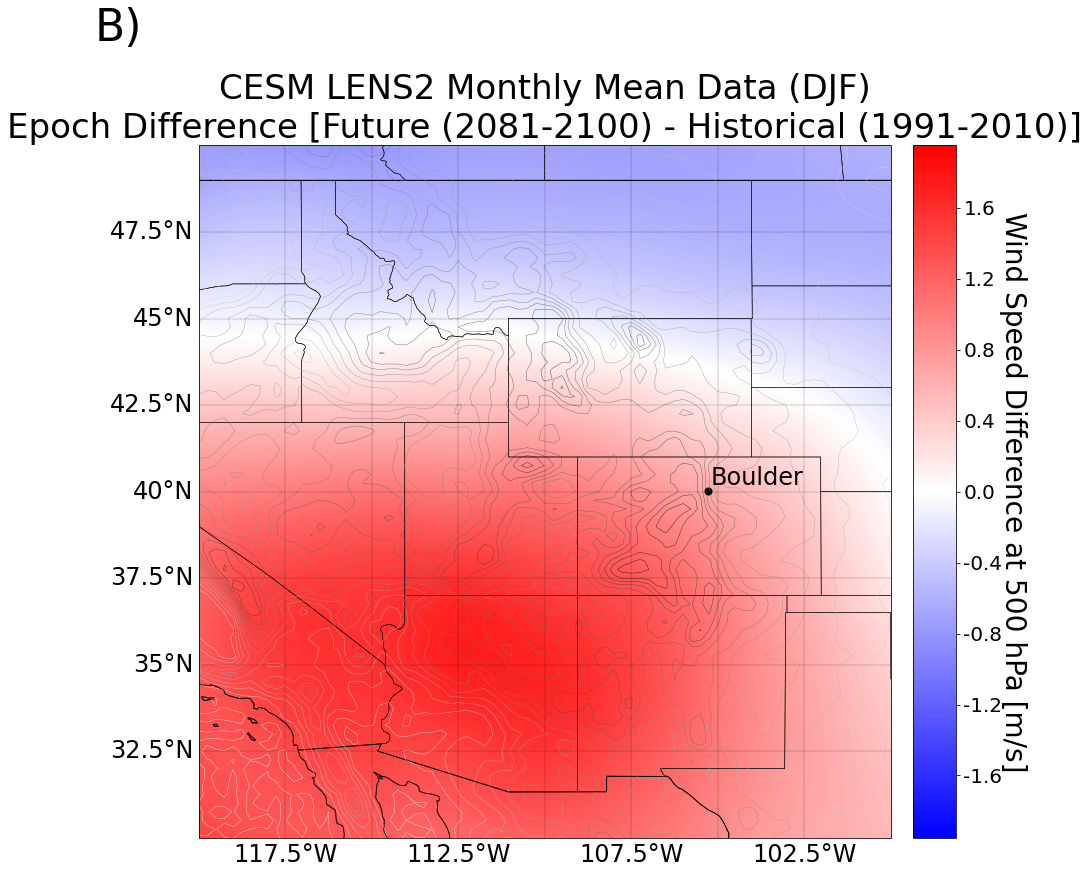

In [8]:
# Create figure and axes objects
fig = plt.figure(figsize=(14,12))
ax = plt.axes(projection=ccrs.PlateCarree())

# Bound and fill in nice lines
#Only look at the Western US
min_lon = 360 - 120
max_lon = 360 - 100
min_lat = 30
max_lat = 50
ax.set_extent([min_lon, max_lon, min_lat, max_lat])
#add in some lines
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES,linewidth=.5)

font_size_title = 34
font_size_label = 28
font_size_num = 24
font_size_boulder = 20

#Lat/Lon lines
g = ax.gridlines(linestyle='--', color='k', linewidth=.25, draw_labels=True,
                 xlabel_style={'size': font_size_num, 'color': 'k'}, ylabel_style={'size': font_size_num, 'color': 'k'})
g.xlabels_top = False
g.ylabels_right = False

wind_lev= np.arange(-2,2.01,0.01)

im=ax.contourf(WS_anom['lon'],
    WS_anom['lat'],
    WS_anom_500interp, 
    levels=wind_lev, cmap='bwr',
    projection=ccrs.PlateCarree()) #cmap=plt.cm.terrain,

#add in topography
contourline = plt.contour(z.variables['longitude'][:], z.variables['latitude'][:], z.z.isel(time=0)/9.80665, transform=ccrs.PlateCarree(),
                          levels=np.arange(0,3500,250), cmap='gist_gray_r', linewidths=.35)

# Add important info to the plot
plt.title("CESM LENS2 Monthly Mean Data (DJF)\nEpoch Difference [Future (2081-2100) - Historical (1991-2010)]", fontsize=font_size_title, pad=8) ##\n525-hPa Wind Speed Anomaly 
#Label for paper
ax.text(-.15, 1.2, 'B)', transform=ax.transAxes, fontsize=44, va='top', ha='left')
cb = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.025, aspect=16,format=tkr.FormatStrFormatter('%.1f'))
cb.set_label('Wind Speed Difference at 500 hPa [m/s]', fontsize=font_size_label, rotation=-90, labelpad=25)
cb.ax.tick_params(labelsize=font_size_boulder)

#center of boulder: 40.0150° N, 105.2705° W
ax.scatter(-105.2705, 40.0150, marker = 'o', s =50, color = 'black', transform=ccrs.PlateCarree())
ax.text(-105.2,40.2,'Boulder', fontsize=font_size_num, transform=ccrs.PlateCarree())

# Adjust figure height so the xlabel isn't cut off when saved
# plt.gcf().subplots_adjust(bottom=0.15)
fig.tight_layout()
plt.show()
# plt.savefig('test.PNG')

## Standard Deviation Plot
Standard deviation for each grid cell in early and future periods

In [11]:
## Similar to code above, but DO NOT AVERAGE ALONG TIME

DATA_DIRECTORY = '/glade/derecho/scratch/mckenziel/Jan17_1982_CESMLE_10ens/'

################## future ###############################
filenames_U = sorted([f for f in glob.glob(DATA_DIRECTORY+"orig_CESMLENS_10ens_DATA/*SSP370*.h0.U*")])
filenames_V = sorted([f for f in glob.glob(DATA_DIRECTORY+"orig_CESMLENS_10ens_DATA/*SSP370*.h0.V*")])
ds_U = xr.open_mfdataset(filenames_U, 
                       concat_dim = 'time',
                      combine = 'nested',
                      parallel=True)
ds_V = xr.open_mfdataset(filenames_V, 
                       concat_dim = 'time',
                      combine = 'nested',
                      parallel=True)
ds_U_mon_avg_future = ds_U.where(ds_U['time.year'] >= 2081, drop = True)
ds_U_mon_avg_future = ds_U_mon_avg_future.where(ds_U_mon_avg_future['time.year'] < 2101, drop = True)
ds_U_DJF_avg_future = xr.concat([ds_U_mon_avg_future.where(ds_U_mon_avg_future['time.month'] == 12 , drop = True),ds_U_mon_avg_future.where(ds_U_mon_avg_future['time.month'] == 1 , drop = True),
                                 ds_U_mon_avg_future.where(ds_U_mon_avg_future['time.month'] == 2 , drop = True)], dim='time')

ds_V_mon_avg_future = ds_V.where(ds_V['time.year'] >= 2081, drop = True)
ds_V_mon_avg_future = ds_V_mon_avg_future.where(ds_V_mon_avg_future['time.year'] < 2101, drop = True)
ds_V_DJF_avg_future = xr.concat([ds_V_mon_avg_future.where(ds_V_mon_avg_future['time.month'] == 12, drop = True),ds_V_mon_avg_future.where(ds_V_mon_avg_future['time.month'] == 1, drop = True),
                                 ds_V_mon_avg_future.where(ds_V_mon_avg_future['time.month'] == 2, drop = True)],dim='time')

########### historical #################
filenames_U_hist = sorted([f for f in glob.glob(DATA_DIRECTORY+"orig_CESMLENS_10ens_DATA/*HIST*.h0.U*")])
filenames_V_hist = sorted([f for f in glob.glob(DATA_DIRECTORY+"orig_CESMLENS_10ens_DATA/*HIST*.h0.V*")])

ds_U_hist = xr.open_mfdataset(filenames_U_hist, 
                       concat_dim = 'time',
                      combine = 'nested',
                      parallel=True)
ds_V_hist = xr.open_mfdataset(filenames_V_hist, 
                       concat_dim = 'time',
                      combine = 'nested',
                      parallel=True)

ds_U_mon_avg_hist = ds_U_hist.where(ds_U_hist['time.year'] >= 1991, drop = True)
ds_U_mon_avg_hist = ds_U_mon_avg_hist.where(ds_U_mon_avg_hist['time.year'] < 2011, drop = True)
ds_U_DJF_avg_hist = xr.concat([ds_U_mon_avg_hist.where(ds_U_mon_avg_hist['time.month'] == 12, drop = True), ds_U_mon_avg_hist.where(ds_U_mon_avg_hist['time.month'] == 1, drop = True), 
                               ds_U_mon_avg_hist.where(ds_U_mon_avg_hist['time.month'] == 2, drop = True)],dim='time')

ds_V_mon_avg_hist = ds_V_hist.where(ds_V_hist['time.year'] >= 1991, drop = True)
ds_V_mon_avg_hist = ds_V_mon_avg_hist.where(ds_V_mon_avg_hist['time.year'] < 2011, drop = True)
ds_V_DJF_avg_hist = xr.concat([ds_V_mon_avg_hist.where(ds_V_mon_avg_hist['time.month'] == 12, drop = True), ds_V_mon_avg_hist.where(ds_V_mon_avg_hist['time.month'] == 1, drop = True), 
                               ds_V_mon_avg_hist.where(ds_V_mon_avg_hist['time.month'] == 2, drop = True)],dim='time')

WS_future = (ds_U_DJF_avg_future['U']**2 + ds_V_DJF_avg_future['V']**2)**0.5
WS_hist = (ds_U_DJF_avg_hist['U']**2 + ds_V_DJF_avg_hist['V']**2)**0.5

In [12]:
## INTERPOLATE DATA TO 500 HPA

##need levels for the wrf-python function
WS_future_original_levs = np.zeros([len(WS_future.lev),len(WS_future.lat),len(WS_future.lon)])
for i in range(len(WS_future.lev)):
    WS_future_original_levs[i].fill(WS_future.lev[i])

WS_hist_original_levs = np.zeros([len(WS_hist.lev),len(WS_hist.lat),len(WS_hist.lon)])
for i in range(len(WS_hist.lev)):
    WS_hist_original_levs[i].fill(WS_hist.lev[i])

## run the interpolation (NOTE: this takes a long time)
WS_future_500interp = interplevel(WS_future, WS_future_original_levs, 500.0)
WS_hist_500interp = interplevel(WS_hist, WS_hist_original_levs, 500.0)

## calculate the standard deviation for each epoch (future and historical) along the time dimension
std_diff_500hPa = WS_future_500interp.std('time') - WS_hist_500interp.std('time')

Plot:

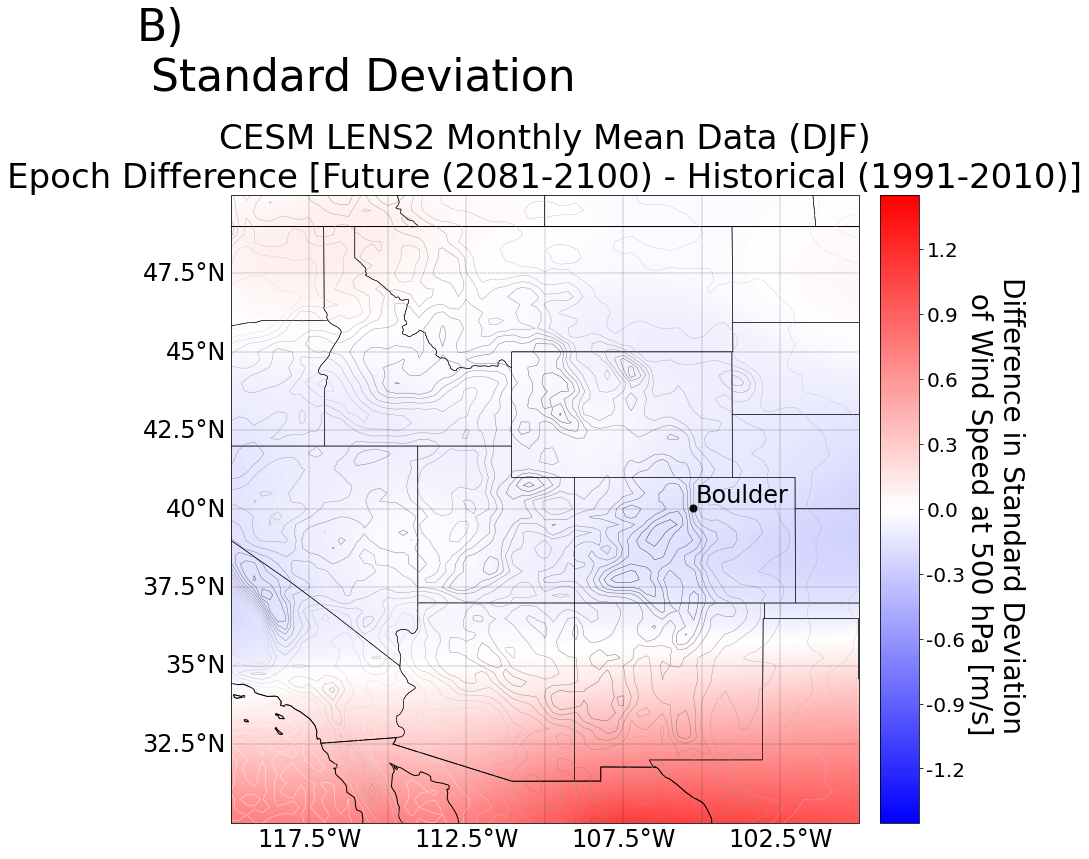

In [13]:
# Create figure and axes objects
fig = plt.figure(figsize=(14,12))
ax = plt.axes(projection=ccrs.PlateCarree())

# Bound and fill in nice lines
#Only look at the Western US
min_lon = 360 - 120
max_lon = 360 - 100
min_lat = 30
max_lat = 50
ax.set_extent([min_lon, max_lon, min_lat, max_lat])
#add in some lines
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES,linewidth=.5)

font_size_title = 34
font_size_label = 28
font_size_num = 24
font_size_boulder = 20
#Lat/Lon lines
g = ax.gridlines(linestyle='--', color='k', linewidth=.25, draw_labels=True,
                 xlabel_style={'size': font_size_num, 'color': 'k'}, ylabel_style={'size': font_size_num, 'color': 'k'})
g.xlabels_top = False
g.ylabels_right = False

wind_lev= np.arange(-1.5,1.51,0.01)

im=ax.contourf(std_diff_500hPa['lon'],
    std_diff_500hPa['lat'],
    std_diff_500hPa, 
     cmap='bwr',levels=wind_lev,
    projection=ccrs.PlateCarree()) #cmap=plt.cm.terrain,levels=wind_lev,

#add in topography
contourline = plt.contour(z.variables['longitude'][:], z.variables['latitude'][:], z.z.isel(time=0)/9.80665, transform=ccrs.PlateCarree(),
                          levels=np.arange(0,3500,250), cmap='gist_gray_r', linewidths=.35)

# Add important info to the plot
plt.title("CESM LENS2 Monthly Mean Data (DJF)\nEpoch Difference [Future (2081-2100) - Historical (1991-2010)]", fontsize=font_size_title, pad=8) ##\n525-hPa Wind Speed Anomaly 
#Label for paper
ax.text(-.15, 1.3, 'B)\n Standard Deviation', transform=ax.transAxes, fontsize=44, va='top', ha='left')

cb = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.025, aspect=16,format=tkr.FormatStrFormatter('%.1f'))
cb.set_label('Difference in Standard Deviation \n of Wind Speed at 500 hPa [m/s]', fontsize=font_size_label, rotation=-90, labelpad=60)
cb.ax.tick_params(labelsize=font_size_boulder)

#center of boulder: 40.0150° N, 105.2705° W
ax.scatter(-105.2705, 40.0150, marker = 'o', s =50, color = 'black', transform=ccrs.PlateCarree())
ax.text(-105.2,40.2,'Boulder', fontsize=font_size_num, transform=ccrs.PlateCarree())

# Adjust figure height so the xlabel isn't cut off when saved
# plt.gcf().subplots_adjust(bottom=0.15)
fig.tight_layout()
plt.show()
# plt.savefig('test.PNG')